In [1]:
from tensorflow.keras import models, layers, utils, backend as K
import matplotlib.pyplot as plt
import shap
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

In [2]:
df=pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')
df.head(5)

HeartDiseaseorAttack  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0                   0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1                   0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2                   0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3                   0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4                   0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   Diabetes  PhysActivity  Fruits  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0       0.0           0.0     0.0  ...            1.0          0.0      5.0   
1       0.0           1.0     0.0  ...            0.0          1.0      3.0   
2       0.0           0.0     1.0  ...            1.0          1.0      5.0   
3       0.0           1.0     1.0  ...            1.0          0.0      2.0   
4       0.0           1.0     1.0  ...            1.0          0.0      2.0   

   MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  Income  
0      18.0      15.0       1.0  0.0   9.0        4.0     3.0  
1       0.0       0.0       0.0  0.0   7.0        6.0     1.0  
2      30.0      30.0       1.0  0.0   9.0        4.0     8.0  
3       0.0       0.0       0.0  0.0  11.0        3.0     6.0  
4       3.0       0.0       0.0  0.0  11.0        5.0     4.0  

[5 rows x 22 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

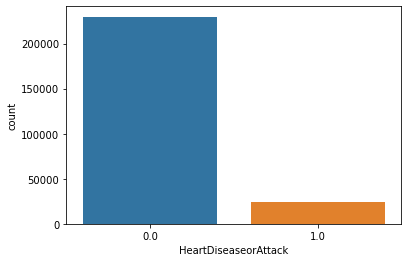

In [4]:
import seaborn as sns 
sns.countplot(data = df, x = df['HeartDiseaseorAttack'])

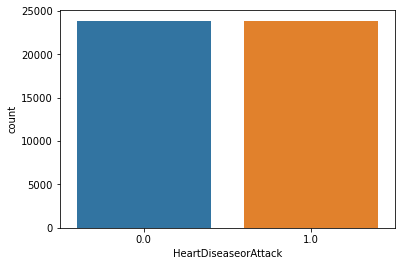

In [5]:
from imblearn.under_sampling import RandomUnderSampler

sampler = RandomUnderSampler(sampling_strategy=1)
new_data = sampler.fit_resample(df.drop('HeartDiseaseorAttack', axis = 1), df['HeartDiseaseorAttack'])

new_df=pd.DataFrame(new_data[0])
new_df['HeartDiseaseorAttack']=new_data[1]
new_df=new_df.sample(frac=1)

sns.countplot(data = new_df.drop('HeartDiseaseorAttack', axis = 1), x = new_df['HeartDiseaseorAttack'])

In [6]:
x = new_df.drop('HeartDiseaseorAttack', axis = 1)
y = new_df['HeartDiseaseorAttack']

In [7]:
#Extract info for each layer in a keras model.
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model):
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers


#Plot the structure of a keras neural network.
def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

In [8]:
def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
def plot_train_val(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))    
    ## training    
    ax[0].set(title="Training")    
    ax11 = ax[0].twinx()    
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')    
    ax[0].set_ylabel('Loss', color='black')    
    for metric in metrics:        
        ax11.plot(training.history[metric], label=metric)
        ax11.set_ylabel("Score", color='steelblue')    
    ax11.legend()
    ## validation    
    ax[1].set(title="Validation")    
    ax22 = ax[1].twinx()    
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')    
    ax[1].set_ylabel('Loss', color='black')    
    for metric in metrics:          
        ax22.plot(training.history['val_'+metric], label=metric)
        ax22.set_ylabel("Score", color="steelblue")    
    plt.show()

# Perceptron

Model: "Perceptron"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 21)]              0         
_________________________________________________________________
output (Dense)               (None, 1)                 22        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


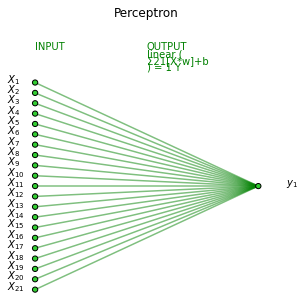

In [10]:
inputs = layers.Input(name="input", shape=(21,))
outputs = layers.Dense(name="output", units=1,activation='linear')(inputs)
model_p1 = models.Model(inputs=inputs, outputs=outputs,name="Perceptron")
model_p1.summary()
visualize_nn(model_p1, description=True, figsize=(5,5))

------------------------------------------------------------------------
Training for fold 1 ...


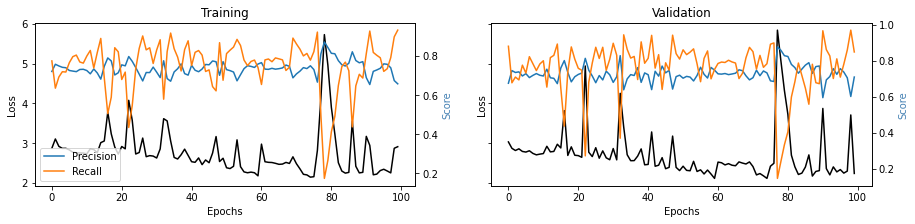

[2.2471673488616943, 0.7166932225227356, 0.8492633700370789]
[2.2199854850769043, 0.713026225566864, 0.8415361642837524]
------------------------------------------------------------------------
Training for fold 2 ...


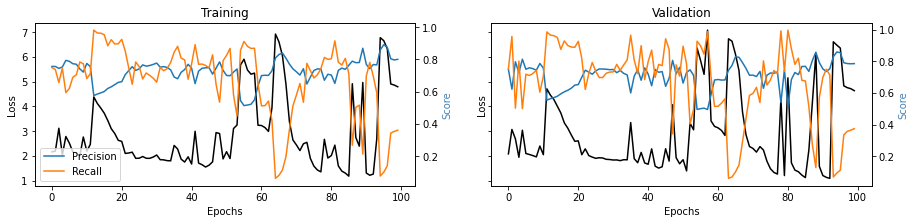

[4.718099594116211, 0.7924647927284241, 0.37012508511543274]
[4.6812591552734375, 0.7888135313987732, 0.3727283477783203]
------------------------------------------------------------------------
Training for fold 3 ...


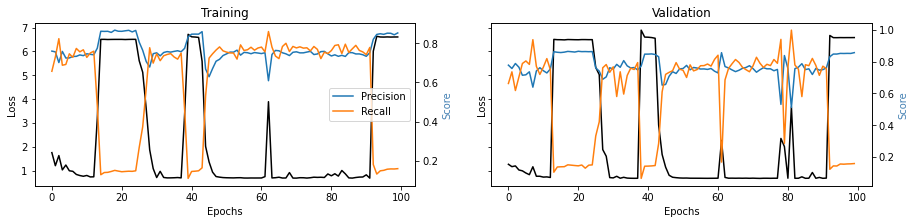

[6.599644184112549, 0.8140562772750854, 0.15848515927791595]
[6.696577072143555, 0.821478545665741, 0.16710248589515686]


In [12]:
kf = KFold(n_splits=3, shuffle=True)

fold_no = 1
train_evaluation_p1 = []
test_evaluation_p1 = []
p1 = []

for train, test in kf.split(x, y):
    model_p1 = models.Model(inputs=inputs, outputs=outputs, name="Perceptron")
    model_p1.compile(optimizer='adam', loss='binary_crossentropy',metrics=[Precision,Recall])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model_p1.fit(x=x.iloc[train], y=y.iloc[train], batch_size=64, epochs=100, shuffle=True, verbose=0, validation_split=0.3)
    plot_train_val(history)
    
    train_evaluation_p1.append(model_p1.evaluate(x.iloc[train],y.iloc[train], verbose=0))
    test_evaluation_p1.append(model_p1.evaluate(x.iloc[test],y.iloc[test], verbose=0))
    p1.append(model_p1)
    
    print(train_evaluation_p1[-1])
    print(test_evaluation_p1[-1])
    
    fold_no = fold_no + 1

In [15]:
print(np.mean(train_evaluation_p1,axis=0))
print(np.mean(test_evaluation_p1,axis=0))

[4.52163704 0.77440476 0.4592912 ]
[4.53260724 0.77443943 0.46045567]


Model: "Perceptron"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 21)]              0         
_________________________________________________________________
output (Dense)               (None, 1)                 22        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


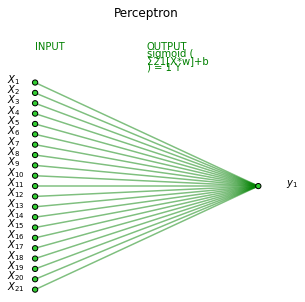

In [16]:
inputs = layers.Input(name="input", shape=(21,))
outputs = layers.Dense(name="output", units=1,activation='sigmoid')(inputs)
model_p2 = models.Model(inputs=inputs, outputs=outputs,name="Perceptron")
model_p2.summary()
visualize_nn(model_p2, description=True, figsize=(5,5))

------------------------------------------------------------------------
Training for fold 1 ...


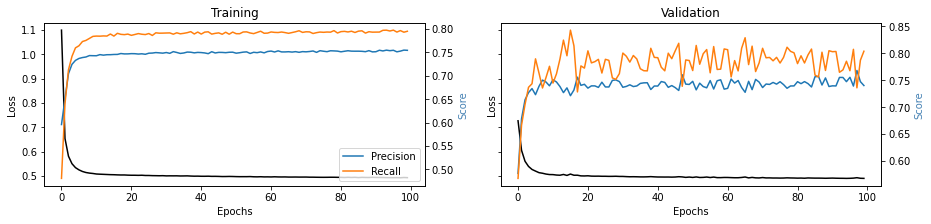

[0.49130746722221375, 0.7467466592788696, 0.8052688837051392]
[0.47952985763549805, 0.7591434121131897, 0.802963137626648]
------------------------------------------------------------------------
Training for fold 2 ...


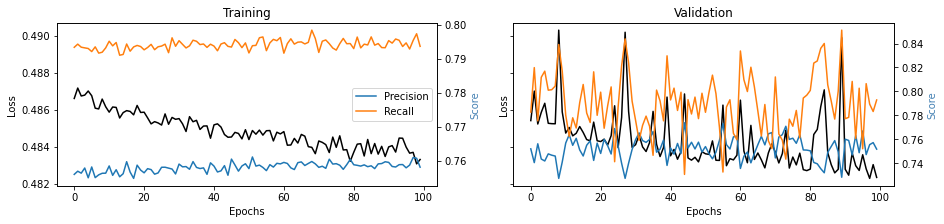

[0.4827222526073456, 0.7562331557273865, 0.7951647043228149]
[0.48708030581474304, 0.7584829926490784, 0.7958945035934448]
------------------------------------------------------------------------
Training for fold 3 ...


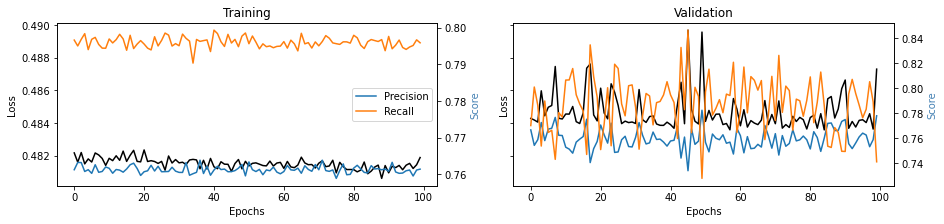

[0.4849870502948761, 0.7788535952568054, 0.7423719167709351]
[0.49216359853744507, 0.7703651785850525, 0.7415236830711365]


In [17]:
kf = KFold(n_splits=3, shuffle=True)

fold_no = 1
train_evaluation_p2 = []
test_evaluation_p2 = []
p2 = []

for train, test in kf.split(x, y):
    model_p2 = models.Model(inputs=inputs, outputs=outputs, name="Perceptron")
    model_p2.compile(optimizer='adam', loss='binary_crossentropy',metrics=[Precision,Recall])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model_p2.fit(x=x.iloc[train], y=y.iloc[train], batch_size=64, epochs=100, shuffle=True, verbose=0, validation_split=0.3)
    plot_train_val(history)
    
    train_evaluation_p2.append(model_p2.evaluate(x.iloc[train],y.iloc[train], verbose=0))
    test_evaluation_p2.append(model_p2.evaluate(x.iloc[test],y.iloc[test], verbose=0))
    p1.append(model_p2)
    
    print(train_evaluation_p2[-1])
    print(test_evaluation_p2[-1])
    
    fold_no = fold_no + 1

In [18]:
print(np.mean(train_evaluation_p2,axis=0))
print(np.mean(test_evaluation_p2,axis=0))

[0.48633892 0.76061114 0.78093517]
[0.48625792 0.76266386 0.78012711]


Model: "Perceptron"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 21)]              0         
_________________________________________________________________
output (Dense)               (None, 1)                 22        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


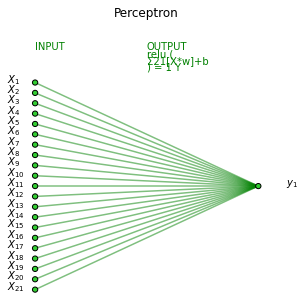

In [19]:
inputs = layers.Input(name="input", shape=(21,))
outputs = layers.Dense(name="output", units=1,activation='relu')(inputs)
model_p3 = models.Model(inputs=inputs, outputs=outputs,name="Perceptron")
model_p3.summary()
visualize_nn(model_p3, description=True, figsize=(5,5))

------------------------------------------------------------------------
Training for fold 1 ...


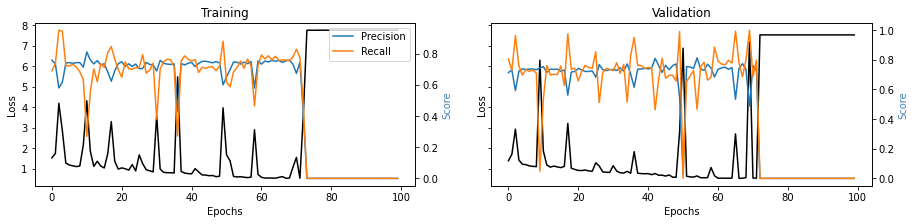

[7.678579807281494, 0.0, 0.0]
[7.779766082763672, 0.0, 0.0]
------------------------------------------------------------------------
Training for fold 2 ...


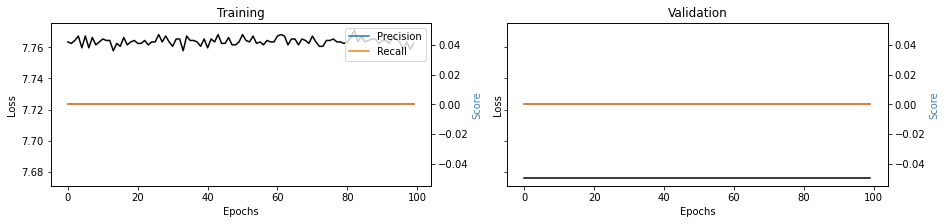

[7.7391357421875, 0.0, 0.0]
[7.658895969390869, 0.0, 0.0]
------------------------------------------------------------------------
Training for fold 3 ...


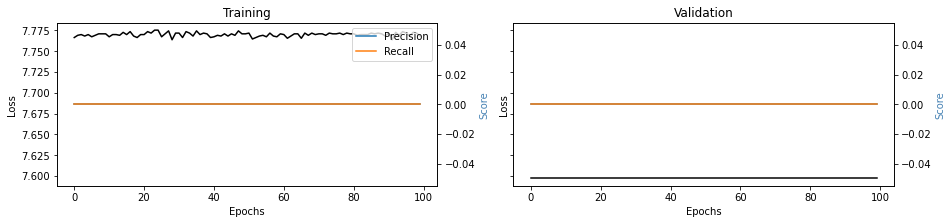

[7.71937370300293, 0.0, 0.0]
[7.6973114013671875, 0.0, 0.0]


In [21]:
kf = KFold(n_splits=3, shuffle=True)

fold_no = 1
train_evaluation_p3 = []
test_evaluation_p3 = []
p3 = []

for train, test in kf.split(x, y):
    model_p3 = models.Model(inputs=inputs, outputs=outputs, name="Perceptron")
    model_p3.compile(optimizer='adam', loss='binary_crossentropy',metrics=[Precision,Recall])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model_p3.fit(x=x.iloc[train], y=y.iloc[train], batch_size=64, epochs=100, shuffle=True, verbose=0, validation_split=0.3)
    plot_train_val(history)
    
    train_evaluation_p3.append(model_p3.evaluate(x.iloc[train],y.iloc[train], verbose=0))
    test_evaluation_p3.append(model_p3.evaluate(x.iloc[test],y.iloc[test], verbose=0))
    p3.append(model_p3)
    
    print(train_evaluation_p3[-1])
    print(test_evaluation_p3[-1])
    
    fold_no = fold_no + 1

In [22]:
print(np.mean(train_evaluation_p3,axis=0))
print(np.mean(test_evaluation_p3,axis=0))

[7.71236308 0.         0.        ]
[7.71199115 0.         0.        ]


# NN

Model: "NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 21)]              0         
_________________________________________________________________
h1 (Dense)                   (None, 5)                 110       
_________________________________________________________________
output (Dense)               (None, 1)                 6         
Total params: 116
Trainable params: 116
Non-trainable params: 0
_________________________________________________________________


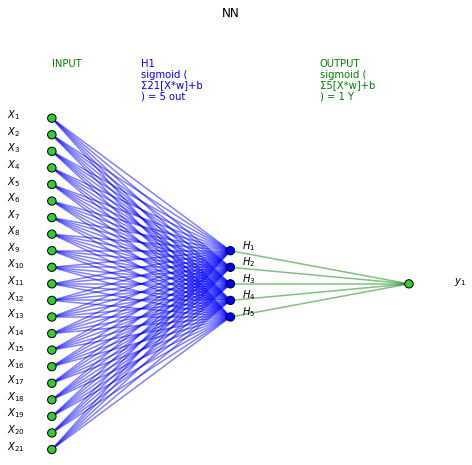

In [25]:
n_features = 21
### layer input
inputs = layers.Input(name="input", shape=(n_features,))
### hidden layer 1
h1 = layers.Dense(name="h1", units=5, activation='sigmoid')(inputs)
### layer output
outputs = layers.Dense(name="output", units=1, activation='sigmoid')(h1)
model_nn0 = models.Model(inputs=inputs, outputs=outputs, name="NN")
model_nn0.summary()
visualize_nn(model_nn0, description=True, figsize=(8,8))

------------------------------------------------------------------------
Training for fold 1 ...


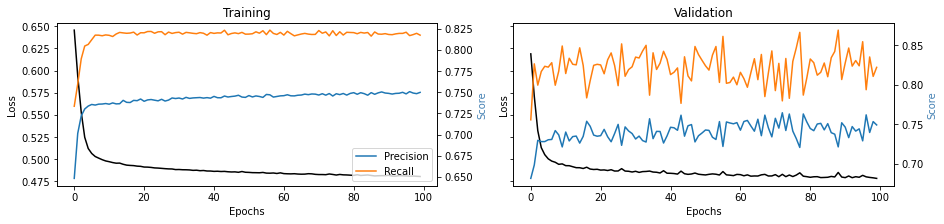

[0.47921937704086304, 0.7486981749534607, 0.8235889077186584]
[0.47896358370780945, 0.7441583871841431, 0.8308565020561218]
------------------------------------------------------------------------
Training for fold 2 ...


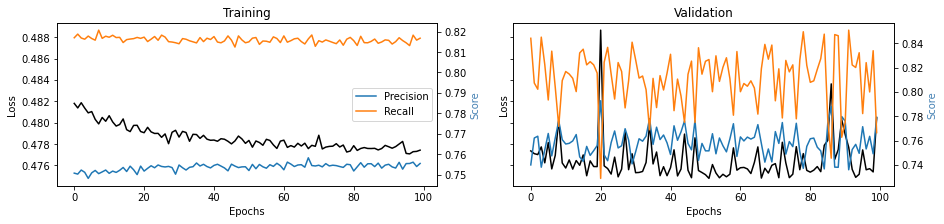

[0.47944143414497375, 0.7756245136260986, 0.7706823348999023]
[0.48434978723526, 0.7682812809944153, 0.7639591693878174]
------------------------------------------------------------------------
Training for fold 3 ...


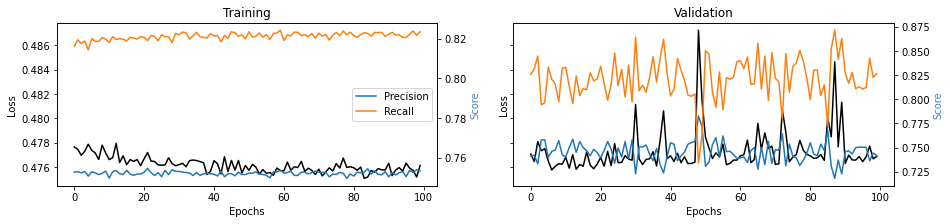

[0.4749321937561035, 0.748252272605896, 0.8297002911567688]
[0.4799147844314575, 0.7511054873466492, 0.8205569386482239]


In [26]:
kf = KFold(n_splits=3, shuffle=True)

fold_no = 1
train_evaluation_nn0 = []
test_evaluation_nn0 = []
nn0 = []

for train, test in kf.split(x, y):
    model_nn0 = models.Model(inputs=inputs, outputs=outputs, name="Perceptron")
    model_nn0.compile(optimizer='adam', loss='binary_crossentropy',metrics=[Precision,Recall])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model_nn0.fit(x=x.iloc[train], y=y.iloc[train], batch_size=64, epochs=100, shuffle=True, verbose=0, validation_split=0.3)
    plot_train_val(history)
    
    train_evaluation_nn0.append(model_nn0.evaluate(x.iloc[train],y.iloc[train], verbose=0))
    test_evaluation_nn0.append(model_nn0.evaluate(x.iloc[test],y.iloc[test], verbose=0))
    nn0.append(model_nn0)
    
    print(train_evaluation_nn0[-1])
    print(test_evaluation_nn0[-1])
    
    fold_no = fold_no + 1

In [27]:
print(np.mean(train_evaluation_nn0,axis=0))
print(np.mean(test_evaluation_nn0,axis=0))

[0.47786433 0.75752499 0.80799051]
[0.48107605 0.75451505 0.8051242 ]


Model: "NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 21)]              0         
_________________________________________________________________
h1 (Dense)                   (None, 10)                220       
_________________________________________________________________
output (Dense)               (None, 1)                 11        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


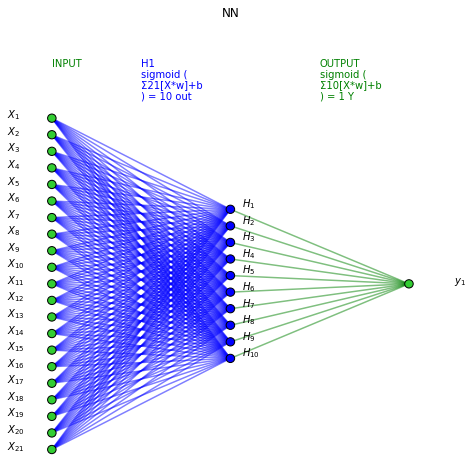

In [14]:
n_features = 21
### layer input
inputs = layers.Input(name="input", shape=(n_features,))
### hidden layer 1
h1 = layers.Dense(name="h1", units=10, activation='sigmoid')(inputs)
### layer output
outputs = layers.Dense(name="output", units=1, activation='sigmoid')(h1)
model_nn1 = models.Model(inputs=inputs, outputs=outputs, name="NN")
model_nn1.summary()
visualize_nn(model_nn1, description=True, figsize=(8,8))

------------------------------------------------------------------------
Training for fold 1 ...


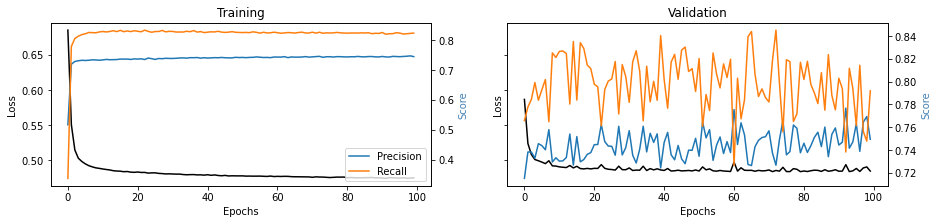

[0.47673672437667847, 0.7494482398033142, 0.8083167672157288]
[0.48282110691070557, 0.7541356086730957, 0.8163628578186035]
------------------------------------------------------------------------
Training for fold 2 ...


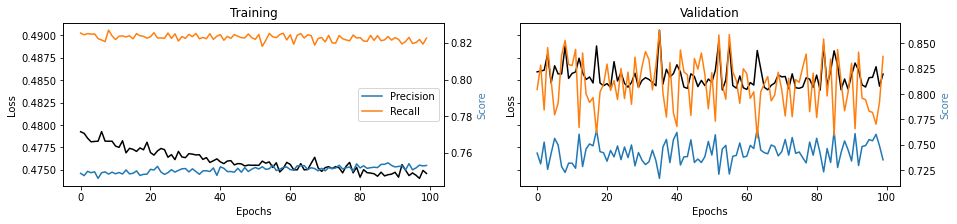

[0.47781217098236084, 0.7387046217918396, 0.842937171459198]
[0.48018404841423035, 0.7364524006843567, 0.8354352712631226]
------------------------------------------------------------------------
Training for fold 3 ...


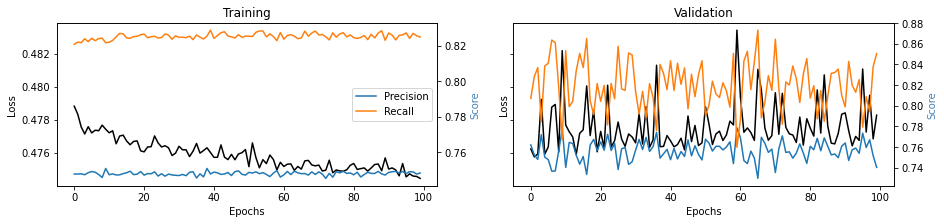

[0.4762992560863495, 0.7349696755409241, 0.8554970622062683]
[0.48377376794815063, 0.7217274308204651, 0.8501845598220825]


In [15]:
kf = KFold(n_splits=3, shuffle=True)

fold_no = 1
train_evaluation_nn1 = []
test_evaluation_nn1 = []
nn1 = []

for train, test in kf.split(x, y):
    model_nn1 = models.Model(inputs=inputs, outputs=outputs, name="Perceptron")
    model_nn1.compile(optimizer='adam', loss='binary_crossentropy',metrics=[Precision,Recall])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model_nn1.fit(x=x.iloc[train], y=y.iloc[train], batch_size=64, epochs=100, shuffle=True, verbose=0, validation_split=0.3)
    plot_train_val(history)
    
    train_evaluation_nn1.append(model_nn1.evaluate(x.iloc[train],y.iloc[train], verbose=0))
    test_evaluation_nn1.append(model_nn1.evaluate(x.iloc[test],y.iloc[test], verbose=0))
    nn1.append(model_nn1)
    
    print(train_evaluation_nn1[-1])
    print(test_evaluation_nn1[-1])
    
    fold_no = fold_no + 1

In [16]:
print(np.mean(train_evaluation_nn1,axis=0))
print(np.mean(test_evaluation_nn1,axis=0))

[0.47694938 0.74104085 0.83558367]
[0.48225964 0.73743848 0.83399423]


Model: "NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 21)]              0         
_________________________________________________________________
h1 (Dense)                   (None, 21)                462       
_________________________________________________________________
output (Dense)               (None, 1)                 22        
Total params: 484
Trainable params: 484
Non-trainable params: 0
_________________________________________________________________


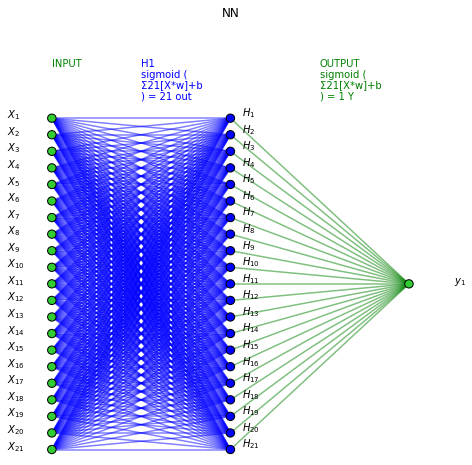

In [26]:
n_features = 21
### layer input
inputs = layers.Input(name="input", shape=(n_features,))
### hidden layer 1
h1 = layers.Dense(name="h1", units=21, activation='sigmoid')(inputs)
### layer output
outputs = layers.Dense(name="output", units=1, activation='sigmoid')(h1)
model_nn2 = models.Model(inputs=inputs, outputs=outputs, name="NN")
model_nn2.summary()
visualize_nn(model_nn2, description=True, figsize=(8,8))

------------------------------------------------------------------------
Training for fold 1 ...


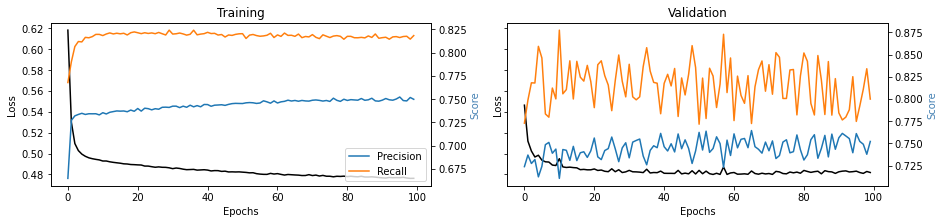

[0.47673603892326355, 0.7547643780708313, 0.8024404048919678]
[0.48107582330703735, 0.7540470361709595, 0.8042908906936646]
------------------------------------------------------------------------
Training for fold 2 ...


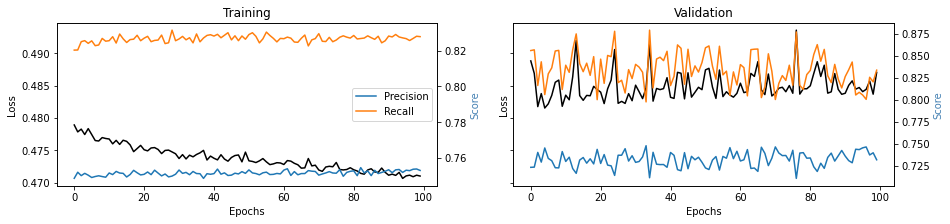

[0.4752075970172882, 0.7443363666534424, 0.8337036967277527]
[0.483534038066864, 0.7464476227760315, 0.8227629065513611]
------------------------------------------------------------------------
Training for fold 3 ...


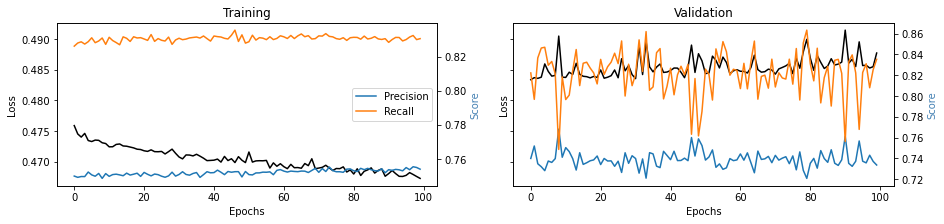

[0.47349968552589417, 0.7429579496383667, 0.843299925327301]
[0.48555347323417664, 0.7346039414405823, 0.8377742767333984]


In [27]:
kf = KFold(n_splits=3, shuffle=True)

fold_no = 1
train_evaluation_nn2 = []
test_evaluation_nn2 = []
nn2 = []

for train, test in kf.split(x, y):
    model_nn2 = models.Model(inputs=inputs, outputs=outputs, name="Perceptron")
    model_nn2.compile(optimizer='adam', loss='binary_crossentropy',metrics=[Precision,Recall])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model_nn2.fit(x=x.iloc[train], y=y.iloc[train], batch_size=64, epochs=100, shuffle=True, verbose=0, validation_split=0.3)
    plot_train_val(history)
    
    train_evaluation_nn2.append(model_nn2.evaluate(x.iloc[train],y.iloc[train], verbose=0))
    test_evaluation_nn2.append(model_nn2.evaluate(x.iloc[test],y.iloc[test], verbose=0))
    nn2.append(model_nn2)
    
    print(train_evaluation_nn2[-1])
    print(test_evaluation_nn2[-1])
    
    fold_no = fold_no + 1

In [28]:
print(np.mean(train_evaluation_nn2,axis=0))
print(np.mean(test_evaluation_nn2,axis=0))

[0.47514777 0.7473529  0.82648134]
[0.48338778 0.74503287 0.82160936]


# Deep

Model: "DeepNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 21)]              0         
_________________________________________________________________
h1 (Dense)                   (None, 10)                220       
_________________________________________________________________
h2 (Dense)                   (None, 5)                 55        
_________________________________________________________________
output (Dense)               (None, 1)                 6         
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


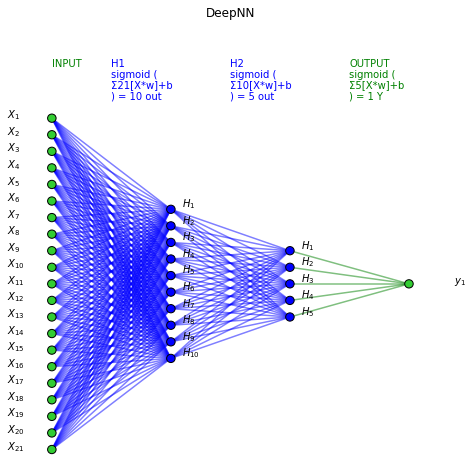

In [25]:
n_features = 21
# DeepNN
### layer input
inputs = layers.Input(name="input", shape=(n_features,))
### hidden layer 1
h1 = layers.Dense(name="h1", units=10, activation='sigmoid')(inputs)
### hidden layer 2
h2 = layers.Dense(name="h2", units=5, activation='sigmoid')(h1)
### layer output
outputs = layers.Dense(name="output", units=1, activation='sigmoid')(h2)
model_dn1 = models.Model(inputs=inputs, outputs=outputs, name="DeepNN")
model_dn1.summary()
visualize_nn(model_dn1, description=True, figsize=(8,8))

------------------------------------------------------------------------
Training for fold 1 ...


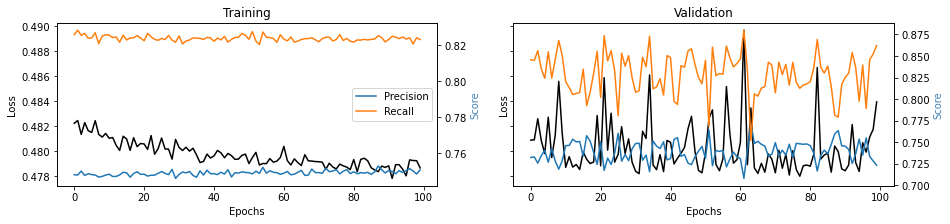

[0.48104044795036316, 0.7278883457183838, 0.8617428541183472]
[0.4835168123245239, 0.72758948802948, 0.8602343201637268]
------------------------------------------------------------------------
Training for fold 2 ...


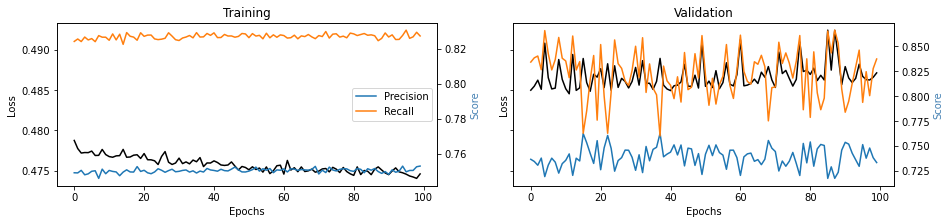

[0.47756078839302063, 0.7416520118713379, 0.8430759310722351]
[0.48195788264274597, 0.7351714968681335, 0.840373158454895]
------------------------------------------------------------------------
Training for fold 3 ...


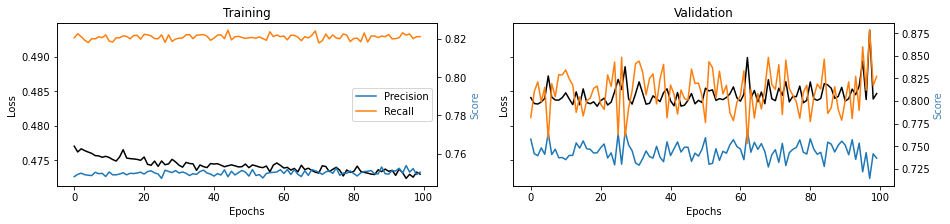

[0.47581642866134644, 0.7409534454345703, 0.8344805240631104]
[0.4835885167121887, 0.744783341884613, 0.835684597492218]


In [58]:
kf = KFold(n_splits=3, shuffle=True)

fold_no = 1
train_evaluation_dn1 = []
test_evaluation_dn1 = []
dn1 =[]

for train, test in kf.split(x, y):
    model_dn1 = models.Model(inputs=inputs, outputs=outputs, name="Perceptron")
    model_dn1.compile(optimizer='adam', loss='binary_crossentropy',metrics=[Precision,Recall])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model_dn1.fit(x=x.iloc[train], y=y.iloc[train], batch_size=64, epochs=100, shuffle=True, verbose=0, validation_split=0.3)
    plot_train_val(history)
    
    train_evaluation_dn1.append(model_dn1.evaluate(x.iloc[train],y.iloc[train], verbose=0))
    test_evaluation_dn1.append(model_dn1.evaluate(x.iloc[test],y.iloc[test], verbose=0))
    dn1.append(model_dn1)
    
    print(train_evaluation_dn1[-1])
    print(test_evaluation_dn1[-1])
    
    fold_no = fold_no + 1

In [59]:
print(np.mean(train_evaluation_dn1,axis=0))
print(np.mean(test_evaluation_dn1,axis=0))

[0.47813922 0.73683127 0.8464331 ]
[0.48302107 0.73584811 0.84543069]


Model: "DeepNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 21)]              0         
_________________________________________________________________
h1 (Dense)                   (None, 10)                220       
_________________________________________________________________
h2 (Dense)                   (None, 5)                 55        
_________________________________________________________________
output (Dense)               (None, 1)                 6         
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


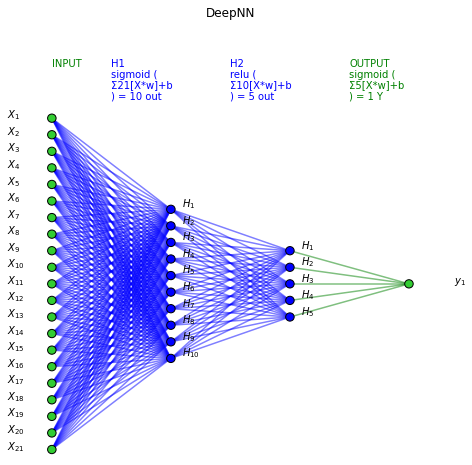

In [63]:
n_features = 21
# DeepNN
### layer input
inputs = layers.Input(name="input", shape=(n_features,))
### hidden layer 1
h1 = layers.Dense(name="h1", units=10, activation='sigmoid')(inputs)
### hidden layer 2
h2 = layers.Dense(name="h2", units=5, activation='relu')(h1)
### layer output
outputs = layers.Dense(name="output", units=1, activation='sigmoid')(h2)
model_dn2 = models.Model(inputs=inputs, outputs=outputs, name="DeepNN")
model_dn2.summary()
visualize_nn(model_dn2, description=True, figsize=(8,8))

------------------------------------------------------------------------
Training for fold 1 ...


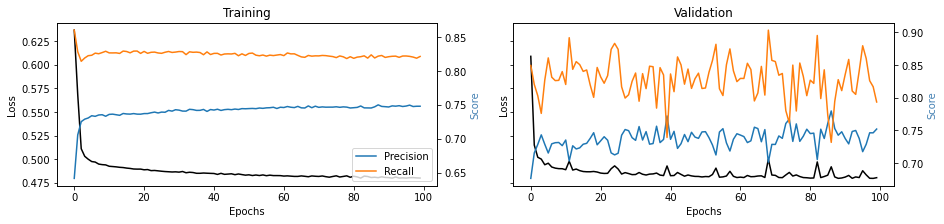

[0.47935590147972107, 0.7584922909736633, 0.7965962290763855]
[0.4816816747188568, 0.7575820088386536, 0.7927059531211853]
------------------------------------------------------------------------
Training for fold 2 ...


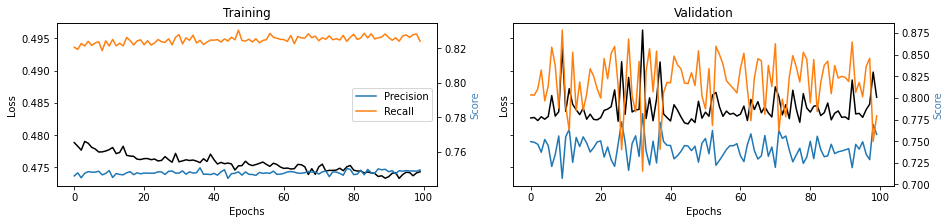

[0.4777942895889282, 0.7629742622375488, 0.7868137955665588]
[0.4877704977989197, 0.7588201761245728, 0.7840031385421753]
------------------------------------------------------------------------
Training for fold 3 ...


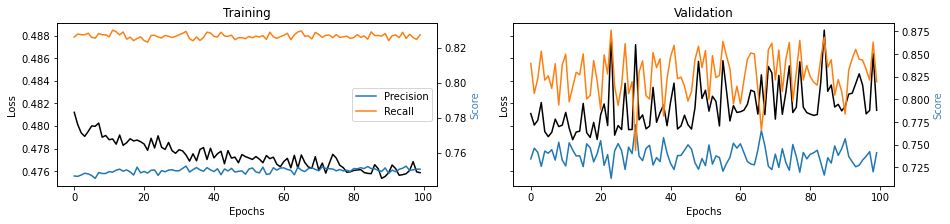

[0.47653183341026306, 0.7508512735366821, 0.821245014667511]
[0.48129767179489136, 0.7433214783668518, 0.8154752850532532]


In [64]:
kf = KFold(n_splits=3, shuffle=True)

fold_no = 1
train_evaluation_dn2 = []
test_evaluation_dn2 = []
dn2=[] 

for train, test in kf.split(x, y):
    model_dn2 = models.Model(inputs=inputs, outputs=outputs, name="Perceptron")
    model_dn2.compile(optimizer='adam', loss='binary_crossentropy',metrics=[Precision,Recall])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model_dn2.fit(x=x.iloc[train], y=y.iloc[train], batch_size=64, epochs=100, shuffle=True, verbose=0, validation_split=0.3)
    plot_train_val(history)
    
    train_evaluation_dn2.append(model_dn2.evaluate(x.iloc[train],y.iloc[train], verbose=0))
    test_evaluation_dn2.append(model_dn2.evaluate(x.iloc[test],y.iloc[test], verbose=0))
    dn2.append(model_dn2)
    
    print(train_evaluation_dn2[-1])
    print(test_evaluation_dn2[-1])
    
    fold_no = fold_no + 1

In [65]:
print(np.mean(train_evaluation_dn2,axis=0))
print(np.mean(test_evaluation_dn2,axis=0))

[0.47789401 0.75743928 0.80155168]
[0.48358328 0.75324122 0.79739479]


Model: "NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 21)]              0         
_________________________________________________________________
h1 (Dense)                   (None, 10)                220       
_________________________________________________________________
h2 (Dense)                   (None, 5)                 55        
_________________________________________________________________
output (Dense)               (None, 1)                 6         
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


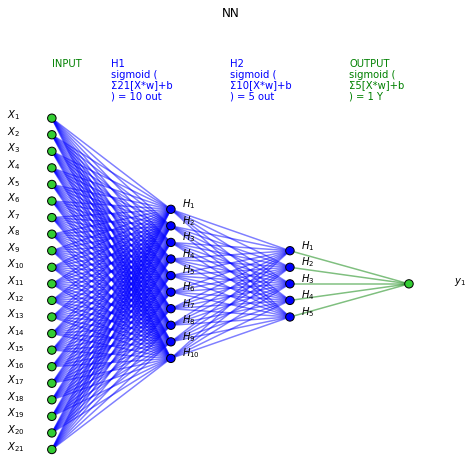

In [60]:
n_features = 21
### layer input
inputs = layers.Input(name="input", shape=(n_features,))
### hidden layer 1
h1 = layers.Dense(name="h1", units=10, activation='sigmoid')(inputs)
### hidden layer 2
h2 = layers.Dense(name="h2", units=5, activation='sigmoid')(h1)
### layer output
### layer output
outputs = layers.Dense(name="output", units=1, activation='sigmoid')(h2)
model_dn3 = models.Model(inputs=inputs, outputs=outputs, name="NN")

model_dn3 .layers[1].set_weights(nn1[1].layers[1].get_weights())
model_dn3 .summary()
visualize_nn(model_dn3 , description=True, figsize=(8,8))

------------------------------------------------------------------------
Training for fold 1 ...


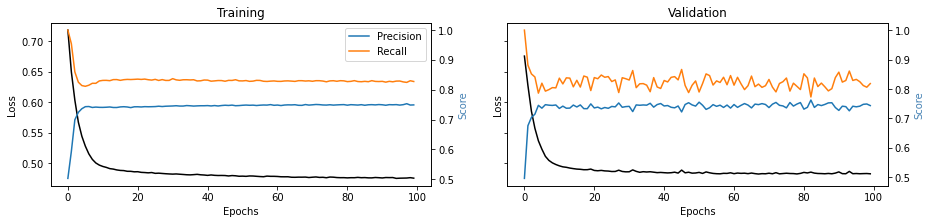

[0.47705718874931335, 0.7490106225013733, 0.8253111839294434]
[0.4836134910583496, 0.7422811388969421, 0.8214054107666016]
------------------------------------------------------------------------
Training for fold 2 ...


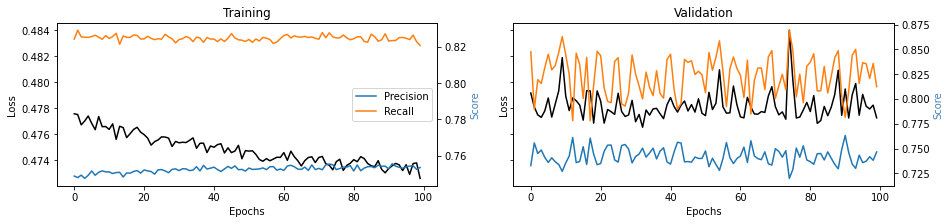

[0.4736247956752777, 0.7563326954841614, 0.8137266039848328]
[0.4860224723815918, 0.7476453185081482, 0.8048034906387329]
------------------------------------------------------------------------
Training for fold 3 ...


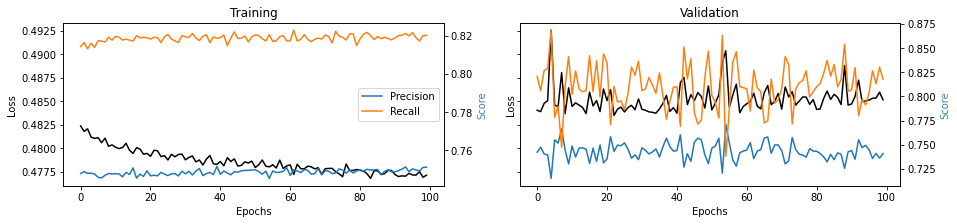

[0.47825056314468384, 0.7458711266517639, 0.8266809582710266]
[0.4737750291824341, 0.7526127099990845, 0.8251529335975647]


In [61]:
kf = KFold(n_splits=3, shuffle=True)

fold_no = 1
train_evaluation_dn3 = []
test_evaluation_dn3 = []
dn3=[] 

for train, test in kf.split(x, y):
    model_dn3 = models.Model(inputs=inputs, outputs=outputs, name="Perceptron")
    model_dn3.compile(optimizer='adam', loss='binary_crossentropy',metrics=[Precision,Recall])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model_dn3.fit(x=x.iloc[train], y=y.iloc[train], batch_size=64, epochs=100, shuffle=True, verbose=0, validation_split=0.3)
    plot_train_val(history)
    
    train_evaluation_dn3.append(model_dn3.evaluate(x.iloc[train],y.iloc[train], verbose=0))
    test_evaluation_dn3.append(model_dn3.evaluate(x.iloc[test],y.iloc[test], verbose=0))
    dn3.append(model_dn3)
    
    print(train_evaluation_dn3[-1])
    print(test_evaluation_dn3[-1])
    
    fold_no = fold_no + 1

In [62]:
print(np.mean(train_evaluation_dn3,axis=0))
print(np.mean(test_evaluation_dn3,axis=0))

[0.47631085 0.75040481 0.82190625]
[0.481137   0.74751306 0.81712061]


# Deeper 

Model: "DeepNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 21)]              0         
_________________________________________________________________
h1 (Dense)                   (None, 10)                220       
_________________________________________________________________
h2 (Dense)                   (None, 5)                 55        
_________________________________________________________________
h3 (Dense)                   (None, 2)                 12        
_________________________________________________________________
output (Dense)               (None, 1)                 3         
Total params: 290
Trainable params: 290
Non-trainable params: 0
_________________________________________________________________


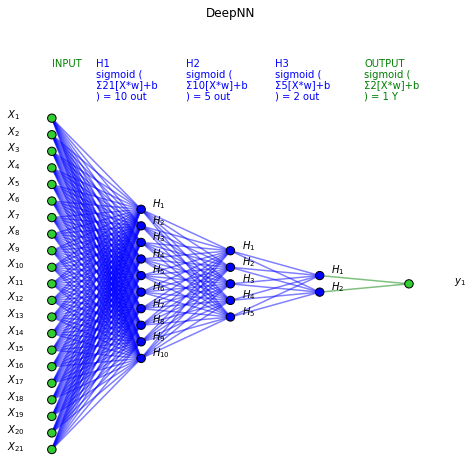

In [66]:
n_features = 21
# DeepNN
### layer input
inputs = layers.Input(name="input", shape=(n_features,))
### hidden layer 1
h1 = layers.Dense(name="h1", units=10, activation='sigmoid')(inputs)
### hidden layer 2
h2 = layers.Dense(name="h2", units=5, activation='sigmoid')(h1)
### hidden layer 3
h3 = layers.Dense(name="h3", units=2, activation='sigmoid')(h2)
### layer output
outputs = layers.Dense(name="output", units=1, activation='sigmoid')(h3)
model_ddn1 = models.Model(inputs=inputs, outputs=outputs, name="DeepNN")
model_ddn1.summary()
visualize_nn(model_ddn1, description=True, figsize=(8,8))

------------------------------------------------------------------------
Training for fold 1 ...


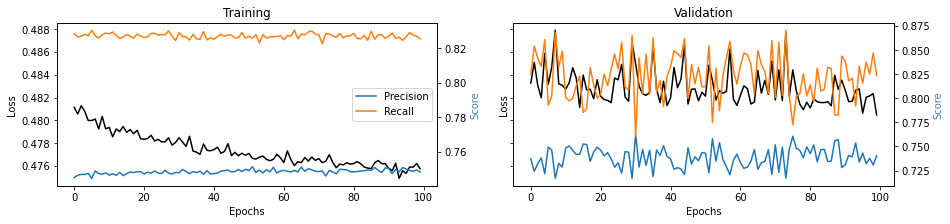

[0.4758833646774292, 0.7498708963394165, 0.8255628347396851]
[0.4841684401035309, 0.7440624237060547, 0.8234753012657166]
------------------------------------------------------------------------
Training for fold 2 ...


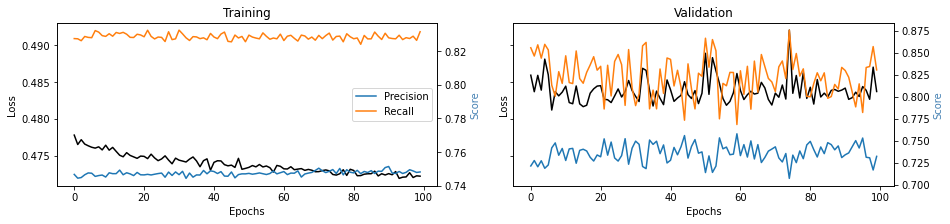

[0.4746265709400177, 0.7413042783737183, 0.8362502455711365]
[0.4864926040172577, 0.7430137395858765, 0.8328404426574707]
------------------------------------------------------------------------
Training for fold 3 ...


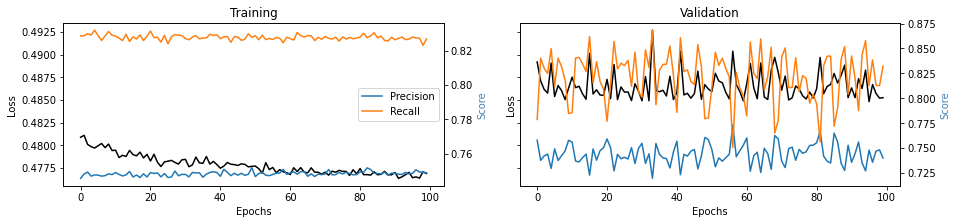

[0.47785401344299316, 0.7449302077293396, 0.8361712098121643]
[0.477091908454895, 0.7364760637283325, 0.834710419178009]


In [68]:
kf = KFold(n_splits=3, shuffle=True)

fold_no = 1
train_evaluation_ddn1 = []
test_evaluation_ddn1 = []
ddn1 = [] 

for train, test in kf.split(x, y):
    model_ddn1 = models.Model(inputs=inputs, outputs=outputs, name="Perceptron")
    model_ddn1.compile(optimizer='adam', loss='binary_crossentropy',metrics=[Precision,Recall])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model_ddn1.fit(x=x.iloc[train], y=y.iloc[train], batch_size=64, epochs=100, shuffle=True, verbose=0, validation_split=0.3)
    plot_train_val(history)
    
    train_evaluation_ddn1.append(model_ddn1.evaluate(x.iloc[train],y.iloc[train], verbose=0))
    test_evaluation_ddn1.append(model_ddn1.evaluate(x.iloc[test],y.iloc[test], verbose=0))
    ddn1.append(model_ddn1)
    
    print(train_evaluation_ddn1[-1])
    print(test_evaluation_ddn1[-1])
    
    fold_no = fold_no + 1

In [69]:
print(np.mean(train_evaluation_ddn1,axis=0))
print(np.mean(test_evaluation_ddn1,axis=0))

[0.47612132 0.74536846 0.83266143]
[0.48258432 0.74118408 0.83034205]


Model: "DeepNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 21)]              0         
_________________________________________________________________
h1 (Dense)                   (None, 21)                462       
_________________________________________________________________
h2 (Dense)                   (None, 10)                220       
_________________________________________________________________
h3 (Dense)                   (None, 5)                 55        
_________________________________________________________________
output (Dense)               (None, 1)                 6         
Total params: 743
Trainable params: 743
Non-trainable params: 0
_________________________________________________________________


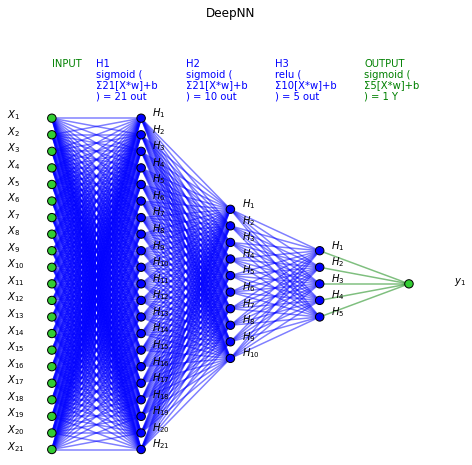

In [107]:
n_features = 21
# DeepNN
### layer input
inputs = layers.Input(name="input", shape=(n_features,))
### hidden layer 1
h1 = layers.Dense(name="h1", units=21, activation='sigmoid')(inputs)
### hidden layer 2
h2 = layers.Dense(name="h2", units=10, activation='sigmoid')(h1)
### hidden layer 3
h3 = layers.Dense(name="h3", units=5, activation='relu')(h2)
### layer output
outputs = layers.Dense(name="output", units=1, activation='sigmoid')(h3)
model_ddn2 = models.Model(inputs=inputs, outputs=outputs, name="DeepNN")
model_ddn2.summary()
visualize_nn(model_ddn2, description=True, figsize=(8,8))

------------------------------------------------------------------------
Training for fold 1 ...


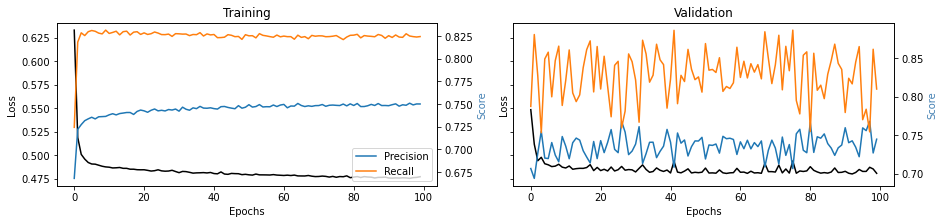

[0.4756304919719696, 0.7534787058830261, 0.809651255607605]
[0.48127204179763794, 0.7558633089065552, 0.8023245930671692]
------------------------------------------------------------------------
Training for fold 2 ...


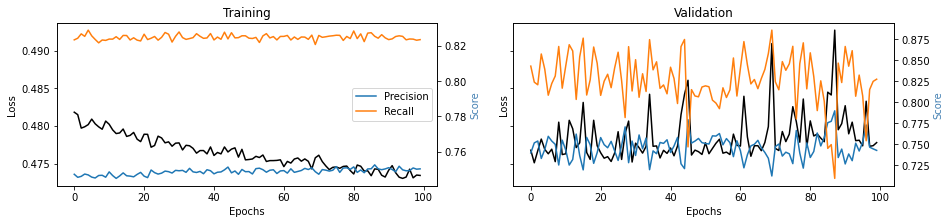

[0.4729427397251129, 0.7441290020942688, 0.8332600593566895]
[0.4830595552921295, 0.7361282706260681, 0.8357717990875244]
------------------------------------------------------------------------
Training for fold 3 ...


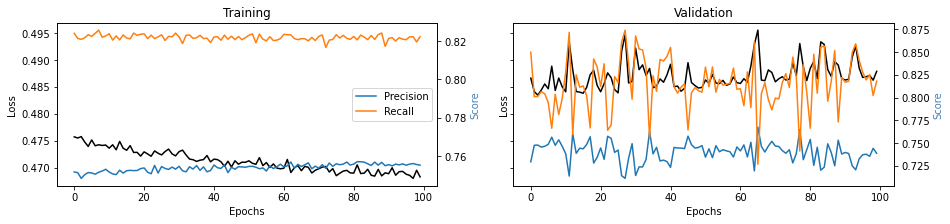

[0.4724339246749878, 0.7502623200416565, 0.8259731531143188]
[0.48178061842918396, 0.7460820078849792, 0.8207142949104309]


In [108]:
kf = KFold(n_splits=3, shuffle=True)

fold_no = 1
train_evaluation_ddn2 = []
test_evaluation_ddn2 = []
ddn2 = [] 

for train, test in kf.split(x, y):
    model_ddn2 = models.Model(inputs=inputs, outputs=outputs, name="Perceptron")
    model_ddn2.compile(optimizer='adam', loss='binary_crossentropy',metrics=[Precision,Recall])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model_ddn2.fit(x=x.iloc[train], y=y.iloc[train], batch_size=64, epochs=100, shuffle=True, verbose=0, validation_split=0.3)
    plot_train_val(history)
    
    train_evaluation_ddn2.append(model_ddn2.evaluate(x.iloc[train],y.iloc[train], verbose=0))
    test_evaluation_ddn2.append(model_ddn2.evaluate(x.iloc[test],y.iloc[test], verbose=0))
    ddn1.append(model_ddn2)
    
    print(train_evaluation_ddn2[-1])
    print(test_evaluation_ddn2[-1])
    
    fold_no = fold_no + 1

In [109]:
print(np.mean(train_evaluation_ddn2,axis=0))
print(np.mean(test_evaluation_ddn2,axis=0))

[0.47366905 0.74929001 0.82296149]
[0.48203741 0.74602453 0.81960356]


# test and trial on ddn1

Model: "DeepNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 21)]              0         
_________________________________________________________________
h1 (Dense)                   (None, 10)                220       
_________________________________________________________________
h2 (Dense)                   (None, 5)                 55        
_________________________________________________________________
drop2 (Dropout)              (None, 5)                 0         
_________________________________________________________________
h3 (Dense)                   (None, 2)                 12        
_________________________________________________________________
output (Dense)               (None, 1)                 3         
Total params: 290
Trainable params: 290
Non-trainable params: 0
______________________________________________________________

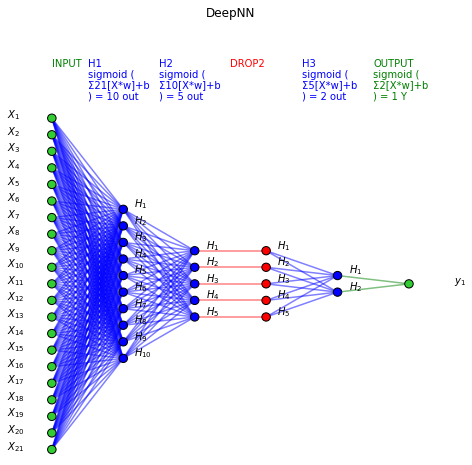

In [111]:
n_features = 21
# DeepNN
### layer input
inputs = layers.Input(name="input", shape=(n_features,))
### hidden layer 1
h1 = layers.Dense(name="h1", units=10, activation='sigmoid')(inputs)
### hidden layer 2
h2 = layers.Dense(name="h2", units=5, activation='sigmoid')(h1)
#adding drop2 
h2 = layers.Dropout(name="drop2", rate=0.1)(h2)
### hidden layer 3
h3 = layers.Dense(name="h3", units=2, activation='sigmoid')(h2)
### layer output
outputs = layers.Dense(name="output", units=1, activation='sigmoid')(h3)
model_tt1 = models.Model(inputs=inputs, outputs=outputs, name="DeepNN")
model_tt1.summary()
visualize_nn(model_tt1, description=True, figsize=(8,8))

------------------------------------------------------------------------
Training for fold 1 ...


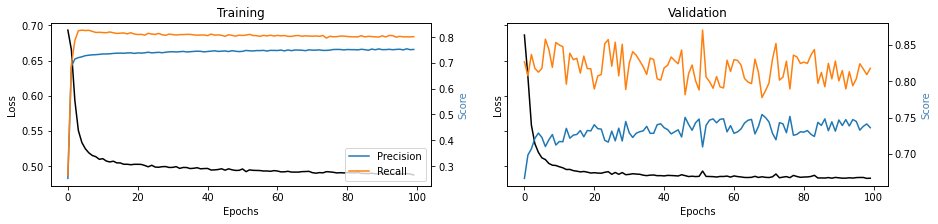

[0.4815295934677124, 0.7452749013900757, 0.8220553994178772]
[0.4834166169166565, 0.7459993958473206, 0.8285762667655945]
------------------------------------------------------------------------
Training for fold 2 ...


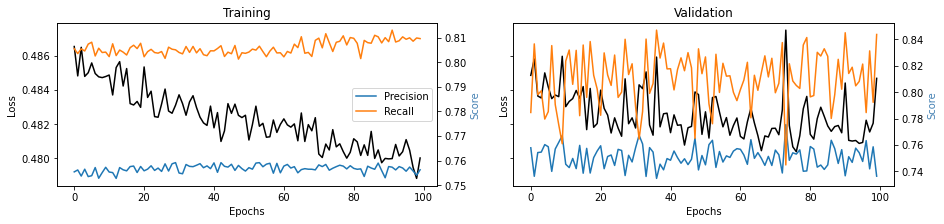

[0.47853705286979675, 0.7379330396652222, 0.8509539365768433]
[0.49037522077560425, 0.7269427180290222, 0.8479406833648682]
------------------------------------------------------------------------
Training for fold 3 ...


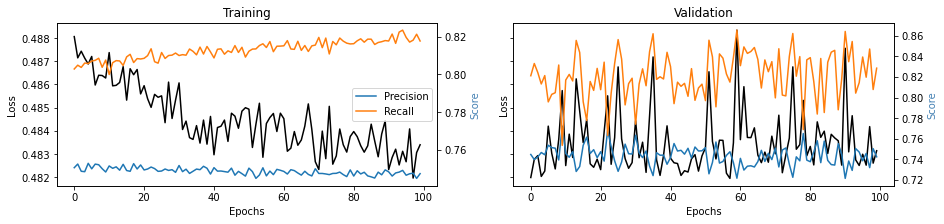

[0.4798170030117035, 0.7462643384933472, 0.8274998068809509]
[0.4772287607192993, 0.7524943351745605, 0.81612229347229]


In [112]:
kf = KFold(n_splits=3, shuffle=True)

fold_no = 1
train_evaluation_tt1 = []
test_evaluation_tt1 = []
tt1 = []

for train, test in kf.split(x, y):
    model_tt1 = models.Model(inputs=inputs, outputs=outputs, name="Perceptron")
    model_tt1.compile(optimizer='adam', loss='binary_crossentropy',metrics=[Precision,Recall])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model_tt1.fit(x=x.iloc[train], y=y.iloc[train], batch_size=64, epochs=100, shuffle=True, verbose=0, validation_split=0.3)
    plot_train_val(history)
    
    train_evaluation_tt1.append(model_tt1.evaluate(x.iloc[train],y.iloc[train], verbose=0))
    test_evaluation_tt1.append(model_tt1.evaluate(x.iloc[test],y.iloc[test], verbose=0))
    tt1.append(model_tt1)
    
    print(train_evaluation_tt1[-1])
    print(test_evaluation_tt1[-1])
    
    fold_no = fold_no + 1

In [114]:
print(np.mean(train_evaluation_tt1,axis=0))
print(np.mean(test_evaluation_tt1,axis=0))

[0.47996122 0.74315743 0.83350305]
[0.48367353 0.74181215 0.83087975]


Model: "DeepNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 21)]              0         
_________________________________________________________________
h1 (Dense)                   (None, 10)                220       
_________________________________________________________________
drop1 (Dropout)              (None, 10)                0         
_________________________________________________________________
h2 (Dense)                   (None, 5)                 55        
_________________________________________________________________
h3 (Dense)                   (None, 2)                 12        
_________________________________________________________________
output (Dense)               (None, 1)                 3         
Total params: 290
Trainable params: 290
Non-trainable params: 0
______________________________________________________________

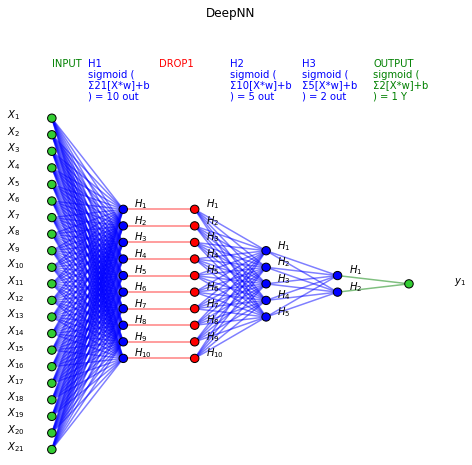

In [116]:
n_features = 21
# DeepNN
### layer input
inputs = layers.Input(name="input", shape=(n_features,))
### hidden layer 1
h1 = layers.Dense(name="h1", units=10, activation='sigmoid')(inputs)
#adding drop1 
h1 = layers.Dropout(name="drop1", rate=0.1)(h1)
### hidden layer 2
h2 = layers.Dense(name="h2", units=5, activation='sigmoid')(h1)
### hidden layer 3
h3 = layers.Dense(name="h3", units=2, activation='sigmoid')(h2)
### layer output
outputs = layers.Dense(name="output", units=1, activation='sigmoid')(h3)
model_tt2 = models.Model(inputs=inputs, outputs=outputs, name="DeepNN")
model_tt2.summary()
visualize_nn(model_tt2, description=True, figsize=(8,8))

------------------------------------------------------------------------
Training for fold 1 ...


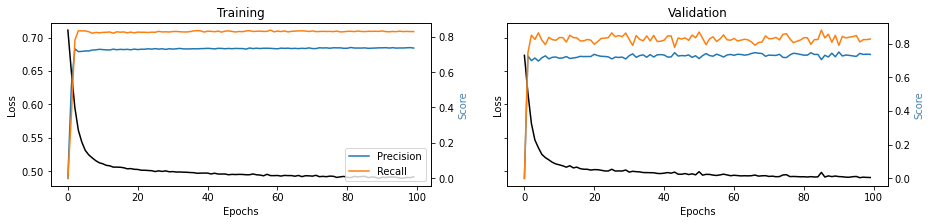

[0.486525297164917, 0.7387261390686035, 0.8314035534858704]
[0.4798243045806885, 0.7422265410423279, 0.8423247933387756]
------------------------------------------------------------------------
Training for fold 2 ...


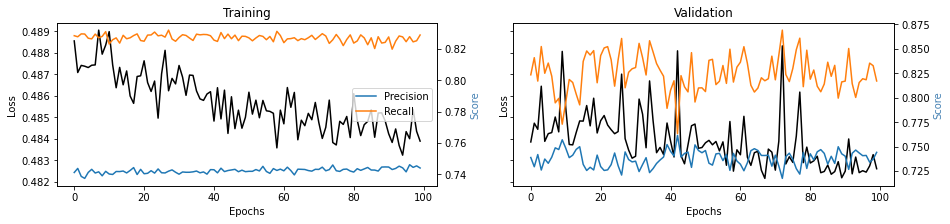

[0.4800558090209961, 0.747009813785553, 0.819595456123352]
[0.4836830496788025, 0.7492932677268982, 0.8157013058662415]
------------------------------------------------------------------------
Training for fold 3 ...


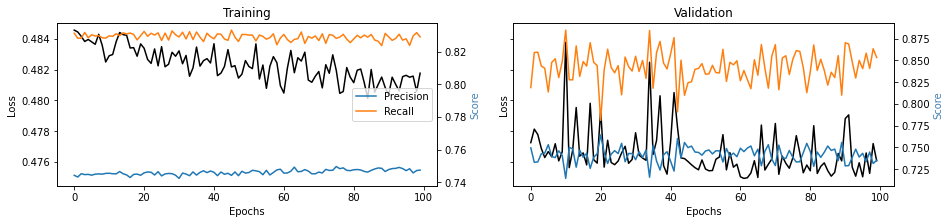

[0.47577011585235596, 0.7407745718955994, 0.8489909768104553]
[0.4881289005279541, 0.7302094101905823, 0.8355847597122192]


In [117]:
kf = KFold(n_splits=3, shuffle=True)

fold_no = 1
train_evaluation_tt2 = []
test_evaluation_tt2 = []
tt2 = []

for train, test in kf.split(x, y):
    model_tt2 = models.Model(inputs=inputs, outputs=outputs, name="Perceptron")
    model_tt2.compile(optimizer='adam', loss='binary_crossentropy',metrics=[Precision,Recall])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model_tt2.fit(x=x.iloc[train], y=y.iloc[train], batch_size=64, epochs=100, shuffle=True, verbose=0, validation_split=0.3)
    plot_train_val(history)
    
    train_evaluation_tt2.append(model_tt2.evaluate(x.iloc[train],y.iloc[train], verbose=0))
    test_evaluation_tt2.append(model_tt2.evaluate(x.iloc[test],y.iloc[test], verbose=0))
    tt2.append(model_tt2)
    
    print(train_evaluation_tt2[-1])
    print(test_evaluation_tt2[-1])
    
    fold_no = fold_no + 1

In [118]:
print(np.mean(train_evaluation_tt2,axis=0))
print(np.mean(test_evaluation_tt2,axis=0))

[0.48078374 0.74217017 0.83333   ]
[0.48387875 0.74057641 0.83120362]


# using pca before dd1 & dn1

<BarContainer object of 21 artists>

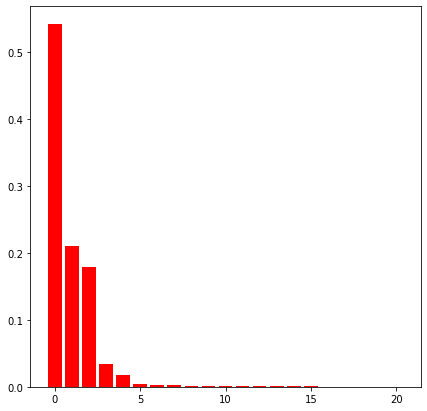

In [13]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x)

fig = plt.figure(figsize=(7, 7))
plt.bar([i for i in range(0,21)], pca.explained_variance_ratio_,color='red')

Model: "DeepNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
h1 (Dense)                   (None, 10)                110       
_________________________________________________________________
h2 (Dense)                   (None, 5)                 55        
_________________________________________________________________
h3 (Dense)                   (None, 2)                 12        
_________________________________________________________________
output (Dense)               (None, 1)                 3         
Total params: 180
Trainable params: 180
Non-trainable params: 0
_________________________________________________________________


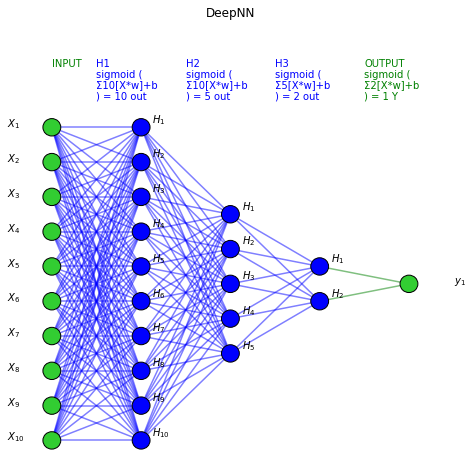

In [14]:
n_features = 10
# DeepNN
### layer input
inputs = layers.Input(name="input", shape=(n_features,))
### hidden layer 1
h1 = layers.Dense(name="h1", units=10, activation='sigmoid')(inputs)
### hidden layer 2
h2 = layers.Dense(name="h2", units=5, activation='sigmoid')(h1)
### hidden layer 3
h3 = layers.Dense(name="h3", units=2, activation='sigmoid')(h2)
### layer output
outputs = layers.Dense(name="output", units=1, activation='sigmoid')(h3)
model_tt3 = models.Model(inputs=inputs, outputs=outputs, name="DeepNN")
model_tt3.summary()
visualize_nn(model_tt3, description=True, figsize=(8,8))

------------------------------------------------------------------------
Training for fold 1 ...


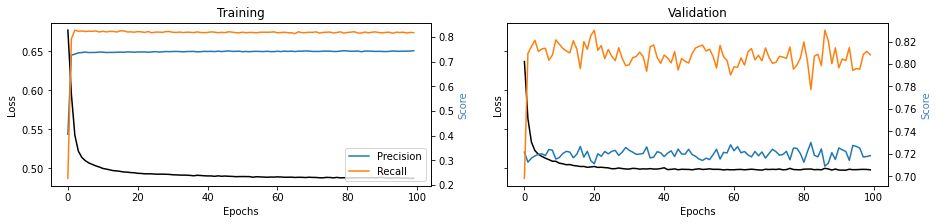

[0.4898258149623871, 0.7331717610359192, 0.817516028881073]
[0.4911562204360962, 0.7381367683410645, 0.8202509880065918]
------------------------------------------------------------------------
Training for fold 2 ...


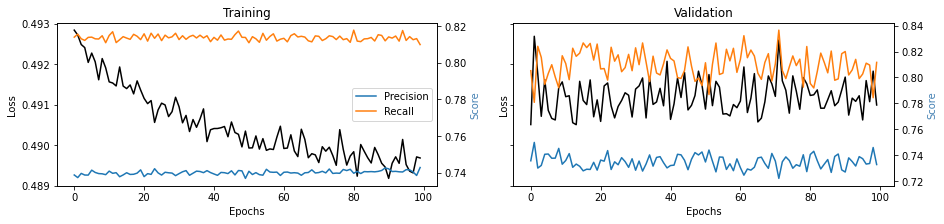

[0.4891837537288666, 0.7368766069412231, 0.8177738785743713]
[0.49091318249702454, 0.7332179546356201, 0.8138254284858704]
------------------------------------------------------------------------
Training for fold 3 ...


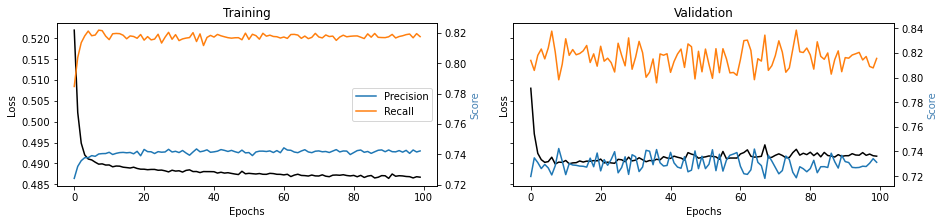

[0.48751193284988403, 0.7386419177055359, 0.816211998462677]
[0.4949653744697571, 0.7328770160675049, 0.8108933568000793]


In [16]:
pca = PCA(10)
kf = KFold(n_splits=3, shuffle=True)

fold_no = 1
train_evaluation_tt3 = []
test_evaluation_tt3 = []
tt3 =[]

for train, test in kf.split(x, y):
    
    pca.fit(x.iloc[train])
    pca_x_train = pca.transform(x.iloc[train])
    pca_x_test = pca.transform(x.iloc[test])
    
    model_tt3 = models.Model(inputs=inputs, outputs=outputs, name="Perceptron")
    model_tt3.compile(optimizer='adam', loss='binary_crossentropy',metrics=[Precision,Recall])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model_tt3.fit(x=pca_x_train, y=y.iloc[train], batch_size=64, epochs=100, shuffle=True, verbose=0, validation_split=0.3)
    plot_train_val(history)
    
    train_evaluation_tt3.append(model_tt3.evaluate(pca_x_train,y.iloc[train], verbose=0))
    test_evaluation_tt3.append(model_tt3.evaluate(pca_x_test,y.iloc[test], verbose=0))
    tt3.append(model_tt3)
    
    print(train_evaluation_tt3[-1])
    print(test_evaluation_tt3[-1])
    
    fold_no = fold_no + 1

In [17]:
print(np.mean(train_evaluation_tt3,axis=0))
print(np.mean(test_evaluation_tt3,axis=0))

[0.4888405 0.7362301 0.8171673]
[0.49234493 0.73474391 0.81498992]


Model: "DeepNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
h1 (Dense)                   (None, 5)                 55        
_________________________________________________________________
h2 (Dense)                   (None, 2)                 12        
_________________________________________________________________
output (Dense)               (None, 1)                 3         
Total params: 70
Trainable params: 70
Non-trainable params: 0
_________________________________________________________________


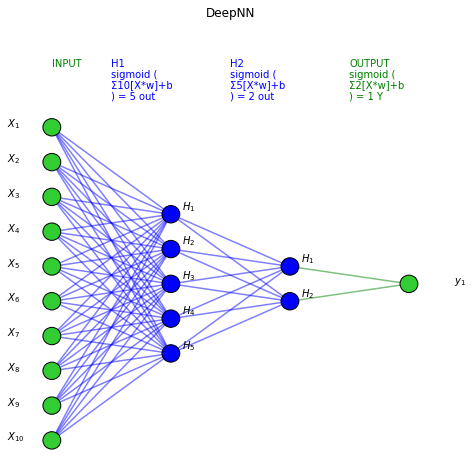

In [21]:
n_features = 10
# DeepNN
### layer input
inputs = layers.Input(name="input", shape=(n_features,))
### hidden layer 1
h1 = layers.Dense(name="h1", units=5, activation='sigmoid')(inputs)
### hidden layer 2
h2 = layers.Dense(name="h2", units=2, activation='sigmoid')(h1)
### layer output
outputs = layers.Dense(name="output", units=1, activation='sigmoid')(h2)
model_tt4 = models.Model(inputs=inputs, outputs=outputs, name="DeepNN")
model_tt4.summary()
visualize_nn(model_tt4, description=True, figsize=(8,8))

------------------------------------------------------------------------
Training for fold 1 ...


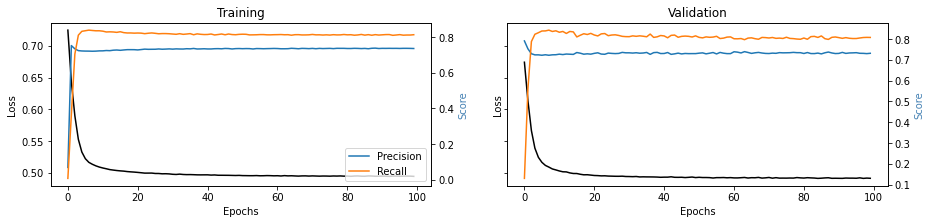

[0.49318450689315796, 0.7337002754211426, 0.8138306140899658]
[0.4900698959827423, 0.7444207668304443, 0.8058894872665405]
------------------------------------------------------------------------
Training for fold 2 ...


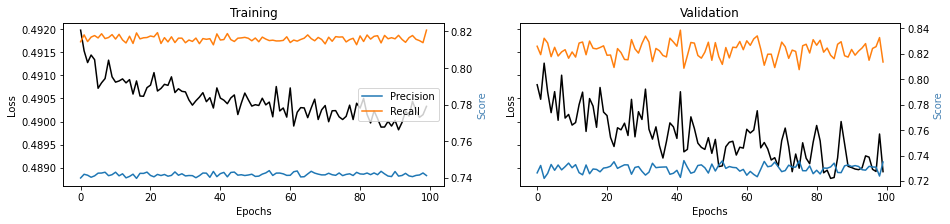

[0.4892072379589081, 0.7424073815345764, 0.8098378777503967]
[0.4946867525577545, 0.7301722168922424, 0.8143056035041809]
------------------------------------------------------------------------
Training for fold 3 ...


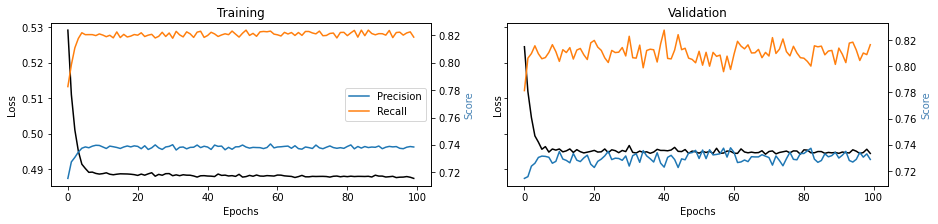

[0.4894254803657532, 0.7337274551391602, 0.8218104839324951]
[0.4931218922138214, 0.7372148633003235, 0.8198837041854858]


In [22]:
pca = PCA(10)
kf = KFold(n_splits=3, shuffle=True)

fold_no = 1
train_evaluation_tt4 = []
test_evaluation_tt4 = []
tt4 =[]

for train, test in kf.split(x, y):
    
    pca.fit(x.iloc[train])
    pca_x_train = pca.transform(x.iloc[train])
    pca_x_test = pca.transform(x.iloc[test])
    
    model_tt4 = models.Model(inputs=inputs, outputs=outputs, name="Perceptron")
    model_tt4.compile(optimizer='adam', loss='binary_crossentropy',metrics=[Precision,Recall])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model_tt4.fit(x=pca_x_train, y=y.iloc[train], batch_size=64, epochs=100, shuffle=True, verbose=0, validation_split=0.3)
    plot_train_val(history)
    
    train_evaluation_tt4.append(model_tt4.evaluate(pca_x_train,y.iloc[train], verbose=0))
    test_evaluation_tt4.append(model_tt4.evaluate(pca_x_test,y.iloc[test], verbose=0))
    tt3.append(model_tt4)
    
    print(train_evaluation_tt4[-1])
    print(test_evaluation_tt4[-1])
    
    fold_no = fold_no + 1

In [23]:
print(np.mean(train_evaluation_tt4,axis=0))
print(np.mean(test_evaluation_tt4,axis=0))

[0.49060574 0.7366117  0.81515966]
[0.49262618 0.73726928 0.8133596 ]


# final

Model: "DeepNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 21)]              0         
_________________________________________________________________
h1 (Dense)                   (None, 10)                220       
_________________________________________________________________
h2 (Dense)                   (None, 5)                 55        
_________________________________________________________________
output (Dense)               (None, 1)                 6         
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


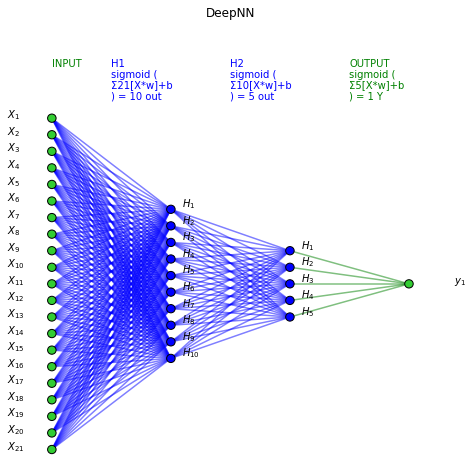

------------------------------------------------------------------------
Training for fold 1 ...
[0.47628679871559143, 0.7331487536430359, 0.8518506288528442]
[0.47144022583961487, 0.7370660305023193, 0.8574204444885254]
------------------------------------------------------------------------
Training for fold 2 ...
[0.4764825403690338, 0.7714750170707703, 0.7674359083175659]
[0.4838511049747467, 0.7679858803749084, 0.7567727565765381]
------------------------------------------------------------------------
Training for fold 3 ...
[0.4712354242801666, 0.7553038597106934, 0.8099011778831482]
[0.486936092376709, 0.7412443161010742, 0.8001203536987305]
------------------------------------------------------------------------
Training for fold 4 ...
[0.47343504428863525, 0.7529782056808472, 0.8134071826934814]
[0.4663904309272766, 0.7539263367652893, 0.8145127892494202]
------------------------------------------------------------------------
Training for fold 5 ...
[0.4720914363861084, 0.74

In [27]:
model = model_dn1
model.summary()
visualize_nn(model, description=True, figsize=(8,8))

kf = KFold(n_splits=10, shuffle=True)

fold_no = 1
train_evaluation = []
test_evaluation = []
kfold_models = []

for train, test in kf.split(x, y):
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=[Precision,Recall])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model.fit(x=x.iloc[train], y=y.iloc[train], batch_size=64, epochs=100, shuffle=True, verbose=0, validation_split=0.3)
    #plot_train_val(history)
    
    train_evaluation.append(model.evaluate(x.iloc[train],y.iloc[train], verbose=0))
    test_evaluation.append(model.evaluate(x.iloc[test],y.iloc[test], verbose=0))
    kfold_models.append(model)
    
    print(train_evaluation[-1])
    print(test_evaluation[-1])
    
    fold_no = fold_no + 1

In [28]:
print("Loss        pecision   Recall")
print(np.mean(train_evaluation,axis=0))
print(np.mean(test_evaluation,axis=0))

Loss        pecision   Recall
[0.4731522  0.74899598 0.8202594 ]
[0.47756034 0.74777663 0.81808778]
